ARIMA MODEL NO DECOMP OR DIFFERNCING PRIOR TO RUNNING

In [41]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt


In [43]:
#filepath
NYT_file="Potential Data Sources/NYT- Cty Cases Deaths Thru Oct2/us-counties.csv"

#read dataset
NYT=pd.read_csv(NYT_file, parse_dates=['date'])

# limit dataset to texas
Texas=NYT.loc[NYT['state']=='Texas'].dropna(how='any', axis=0)
Texas['county']=Texas['county'].map(str)+' County'
Texas2=Texas.drop(['fips', 'state'], axis=1)

### pick a county
CtyName='Harris County'
CountyChoice=Texas2.loc[Texas2['county']==CtyName].set_index('date')
CountyChoice2=CountyChoice.drop('county', axis=1)

# CountyChoice2=Texas2
CountyChoice2

,cases,deaths
date,,
2020-03-05,4,0
2020-03-06,5,0
2020-03-07,5,0
2020-03-08,6,0
2020-03-09,6,0
...,...,...
2020-09-29,142315,2588
2020-09-30,142681,2599
2020-10-01,143530,2607


In [44]:
#param analysis for ARIMA model:
# ref: https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
data=CountyChoice2['cases']

# Import the library 
from pmdarima import auto_arima 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(data, start_p = 1, start_q = 1, 
                          max_p = 10, max_q = 10, m = 12, #monthly
                          start_P = 0, seasonal = True, 
                          stationary=True,
                          trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3640.718, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5187.286, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5325.886, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3650.924, Time=0.45 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=3620.169, Time=1.06 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3634.619, Time=1.12 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=3602.036, Time=2.69 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=3598.781, Time=2.48 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=5016.692, Time=0.63 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.63 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=3598.875, Time=2.57 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  213
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1791.606
Date:                             Thu, 15 Oct 2020   AIC                           3593.212
Time:                                     21:56:39   BIC                           3610.018
Sample:                                          0   HQIC                          3600.004
                                             - 213                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1196.975      0.000       0.998       1.001
ma.L1          0.0898      0.048      1.887      0.059      -0.003       0.183
ar.S.L12       0.1365      0.051      2.651      0.008       0.036       0.237
ar.S.L24       0.6104      0.067      9.113      0.000       0.479       0.742
sigma2      1.061e+06   2.84e-07   3.73e+12      0.000    1.06e+06    1.06e+06
===================================================================================
Ljung-Box (Q):                       22.63   Jarque-Bera (JB):            151586.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             152.92   Skew:                            10.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       132.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.78e+26. Standard errors may be unstable.
"""

In [45]:
# Split data into train / test sets 
# Isolate only the transformed data into a dataframe for the model

# split test train 
end_train=pd.to_datetime('2020-07-31')
start_test=pd.to_datetime('2020-08-01')
train=data[:end_train]
test=data[start_test:]
print(train.shape, test.shape)

(149,) (64,)


In [46]:
# Fit a SARIMAX(1,0,1)(2,0,0,12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

# pull out the parameters of the best model for this county
x=stepwise_fit.get_params()
    
# runs model with best fit ARIMA params
model = SARIMAX(train,  
                order = (x['order']),  
                seasonal_order =(x['seasonal_order']))
   
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               cases   No. Observations:                  149
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1104.028
Date:                             Thu, 15 Oct 2020   AIC                           2218.057
Time:                                     21:56:51   BIC                           2233.076
Sample:                                 03-05-2020   HQIC                          2224.159
                                      - 07-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.81e-06   5.54e+05      0.000       1.000       1.000
ma.L1          0.3669      0.059      6.224      0.000       0.251       0.482
ar.S.L12       0.5942      0.045     13.140      0.000       0.506       0.683
ar.S.L24       0.3066      0.060      5.121      0.000       0.189       0.424
sigma2      1.169e+05   2.66e-07    4.4e+11      0.000    1.17e+05    1.17e+05
===================================================================================
Ljung-Box (Q):                      136.35   Jarque-Bera (JB):               256.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.90   Skew:                             1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+27. Standard errors may be unstable.
"""

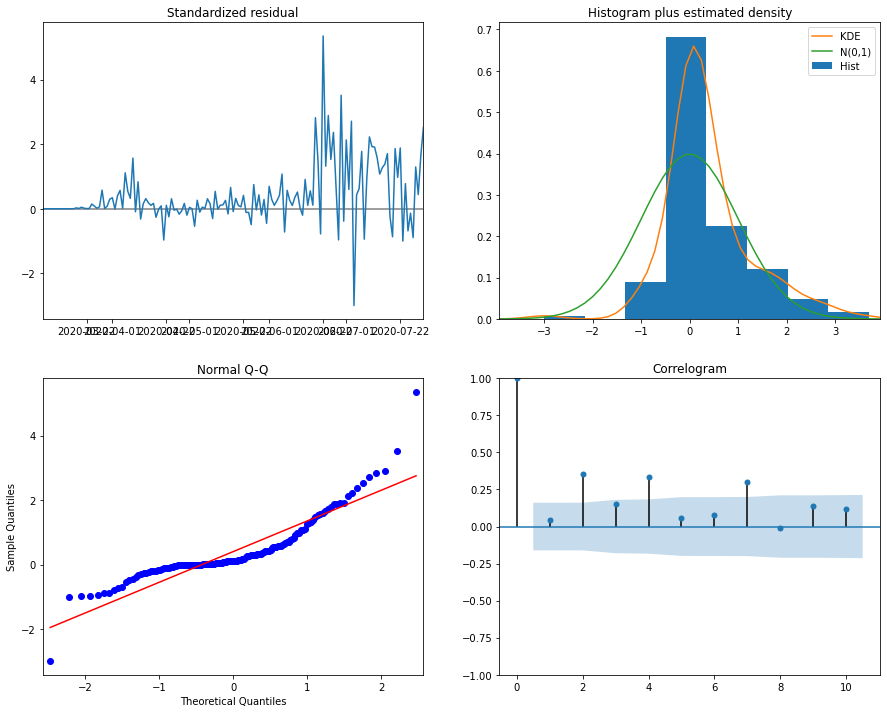

In [48]:
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
result.plot_diagnostics(figsize=(15,12));

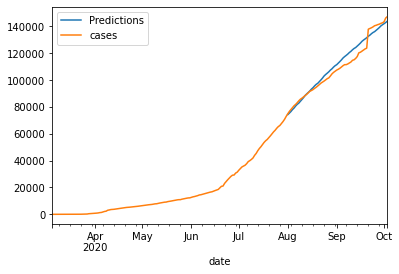

In [49]:
# compare test train
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end).rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
data.plot(legend = True) 

In [50]:
rmse = sqrt(mean_squared_error(predictions, data))

NameError: name 'mean_squared_error' is not defined

In [51]:
#  get results for full dataset:
end=pd.to_datetime('2020-10-03')
start=pd.to_datetime('2020-04-01')
formodel=data[start:end]

model = SARIMAX(formodel,  
                order = (1, 0, 1),  
                seasonal_order =(2, 0, 0, 12)) 
  
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               cases   No. Observations:                  186
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1578.319
Date:                             Thu, 15 Oct 2020   AIC                           3166.639
Time:                                     21:57:16   BIC                           3182.767
Sample:                                 04-01-2020   HQIC                          3173.175
                                      - 10-03-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1082.361      0.000       0.998       1.001
ma.L1          0.0916      0.055      1.675      0.094      -0.016       0.199
ar.S.L12       0.1399      0.058      2.427      0.015       0.027       0.253
ar.S.L24       0.5925      0.076      7.778      0.000       0.443       0.742
sigma2      1.218e+06    2.8e-07   4.35e+12      0.000    1.22e+06    1.22e+06
===================================================================================
Ljung-Box (Q):                       19.91   Jarque-Bera (JB):            102543.22
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             166.53   Skew:                             9.60
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+27. Standard errors may be unstable.
"""

In [36]:
# Getting 120 days (a little more than 6 months in business days) for forecasts
SARIMAX_forecast = round(result.forecast(steps = 90))

idx = pd.date_range('2020-10-04', '2021-01-01', freq='d')
 
SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
columns=['Date','Forcast Cases']).set_index('Date')


print(SARIMAX_forecast)



            Forcast Cases
Date                     
2020-10-04         1009.0
2020-10-05         1009.0
2020-10-06         1009.0
2020-10-07         1008.0
2020-10-08         1008.0
...                   ...
2020-12-28          995.0
2020-12-29          995.0
2020-12-30          994.0
2020-12-31          993.0
2021-01-01          992.0

[90 rows x 1 columns]


(18304.0, 18627.0)

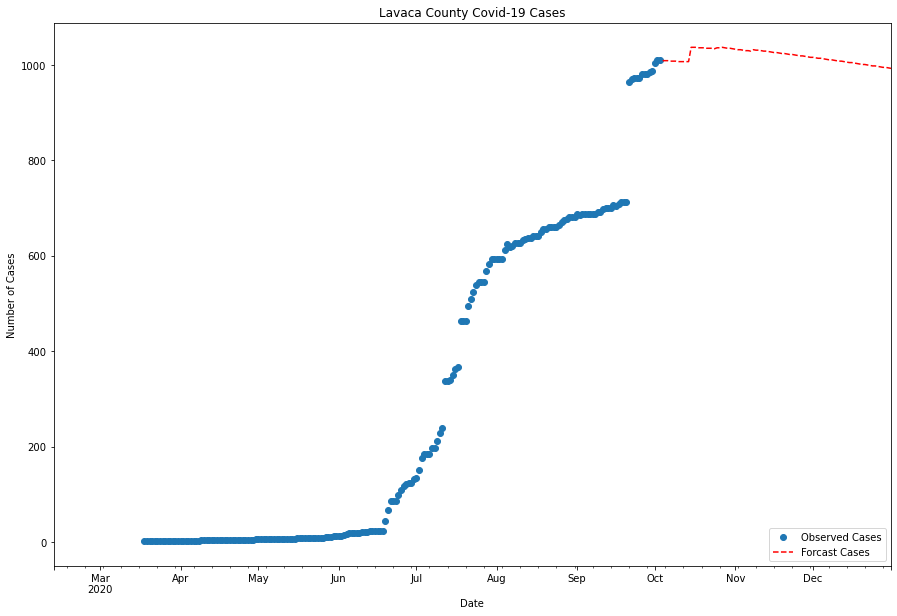

In [39]:
# Graph
fig, ax = plt.subplots(figsize=(15,10))
npre = 4
ax.set(title= f'{CtyName} Covid-19 Cases', xlabel='Date', ylabel='Number of Cases')


# Plot data points
data.loc['2020-02-12':].plot(ax=ax, style='o', label='Observed Cases')

# Plot predictions
SARIMAX_forecast.loc['2020-10-03':].plot(ax=ax, style='r--', label='Sarimax forecast')

# predict.predicted_mean.loc['2020-04-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
# ci = predict_ci.loc['2020-04-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc['2020-04-01':].plot(ax=ax, style='g', label='Dynamic forecast')
# ci = predict_dy_ci.loc['2020-04-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)


legend = ax.legend(loc='lower right')
ax.set_xlim(np.datetime64('2020-02-12'), np.datetime64('2020-12-31'))